In [1]:
library(magrittr)  # nice piping operators
library(tidyverse)  # tables, plotting, read-write
library(Cairo)  # for pdf unicode export
library(stringr)
library(rasilabRtemplates)

# color blind palette
# http://www.cookbook-r.com/Graphs/Colors_(ggplot2)/#a-colorblind-friendly-palette
cbPalette <- c("#000000", "#E69F00", "#56B4E9", 
            "#009E73", "#CC79A7", "#0072B2", "#D55E00", "#F0E442")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract()   masks magrittr::extract()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ purrr::set_names() masks magrittr::set_names()


### Figure 4B

In [2]:
data <- read_tsv('../data/plate_reader/4b_data.tsv')
annotations <- read_csv('../data/plate_reader/4b_ann.csv')

processed_data <- data %>%  
  left_join(annotations, by = c('plate', 'well')) %>% 
  select(-c(date, strain, well, plate)) %>% 
  mutate(od = od - 0.04)

plot_data <- processed_data %>% 
  # control order of variables
  mutate(medium = factor(medium,
                           levels=c("lysis", "-gly","-ala","+1mM_ala","+.0125%_pyr"))) %>%
  mutate(genotype = factor(genotype, levels=c("WT","del_sdaC"))) %>%
  subset(plasmid == 'none') %>%
  subset(medium == '-gly' & time < 480)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  plate = col_integer(),
  well = col_character(),
  time = col_double(),
  od = col_double()
)
Parsed with column specification:
cols(
  well = col_character(),
  strain = col_character(),
  genotype = col_character(),
  plasmid = col_character(),
  medium = col_character(),
  replicate = col_integer(),
  plate = col_integer()
)


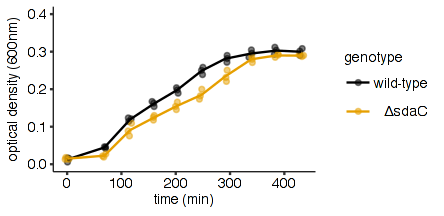

In [3]:
# plot
plot.width = 3.7
plot.height = 1.8
options(repr.plot.width=plot.width, repr.plot.height=plot.height)
ggplot(plot_data, aes(x=time, y=od, col=genotype)) +
geom_point(size=1, alpha=0.5, position = position_jitter(w = 5, h = 0)) + 
scale_y_continuous(limits=c(0,0.4)) + scale_color_manual(values=cbPalette, 
                   labels=c("wild-type", expression(italic("ΔsdaC")))) + 
labs(x = "time (min)", y = "optical density (600nm)", col = "genotype") +
theme(strip.text=element_text(hjust=0.05)) +
stat_summary(aes(group=genotype), fun.y=mean, geom="line")

# save plot
ggsave('../pdf/fig_4b.pdf', width = plot.width, height = plot.height, units = 'in', device=cairo_pdf)

### Figure 4C

In [4]:
data <- read_tsv('../data/plate_reader/4c_data.tsv')
annotations <- read_csv('../data/plate_reader/4c_ann.csv')

processed_data <- data %>%  
  left_join(annotations, by = c('plate', 'well')) %>% 
  select(-c(date, strain, well, plate)) %>% 
  group_by(time, genotype, reporter, medium) %>% 
  mutate(nyfp = yfp / od) %>% 
  summarize(mean_od = mean(od), mean_yfp = mean(yfp), mean_nyfp = mean(nyfp),
            sem_od = sd(od) / sqrt(n()), sem_yfp = sd(yfp) / sqrt(n()),
            sem_nyfp = sd(nyfp) / sqrt(n())) %>% 
  ungroup() %>% 
  # control order of variables
  mutate(medium = factor(medium,
                           levels=c(".025%glucose_noser", ".1%glucose_noser",
                                   ".025%glucose_3mMser"))) %>%
  mutate(reporter = factor(reporter, levels=c("gcvTHP","glyA","kbl-tdh","ltaE",
                                             "sdaCB","serA","vector","none")))

plot_data <- processed_data %>% 
  group_by(genotype, reporter, time) %>% 
  # normalize by high glucose time point
  mutate(nyfp_normglucose = mean_nyfp / mean_nyfp[medium == ".1%glucose_noser"]) %>% 
  ungroup() %>% 
  group_by(genotype, reporter, medium) %>% 
  # select time points after glucose depletion for calculating induction
  subset(200 < time, time < 300)  %>% 
  summarize(mean_induction = mean(nyfp_normglucose),
            sem_induction = sd(nyfp_normglucose) / sqrt(n())) %>% 
  ungroup()

Parsed with column specification:
cols(
  date = col_date(format = ""),
  plate = col_integer(),
  well = col_character(),
  time = col_double(),
  od = col_double(),
  yfp = col_integer()
)
Parsed with column specification:
cols(
  well = col_character(),
  strain = col_character(),
  genotype = col_character(),
  reporter = col_character(),
  medium = col_character(),
  replicate = col_integer(),
  plate = col_integer()
)


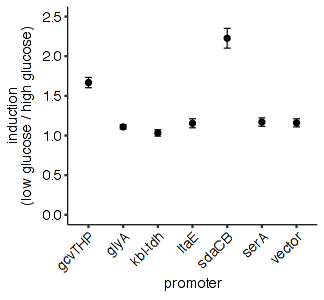

In [5]:
# plot
plot.width = 2.7
plot.height = 2.5
options(repr.plot.width = plot.width, repr.plot.height = plot.height)

facettitles <- c(
    ".025%glucose_noser" = "– Ser",
    ".025%glucose_3mMser" = "+ 3mM Ser"
)

facetlabel <- function(var) {
    facettitles[var]
}

plot_data %>% 
  filter(medium == ".025%glucose_noser" & reporter != "none") %>% 
  ggplot(aes(x=reporter, y=mean_induction)) +
  geom_point(size = 1) + 
  geom_errorbar(aes(ymin = mean_induction - sem_induction, 
                    ymax = mean_induction + sem_induction),
                color = "black", size = 0.25, width = 0.2) +
  scale_color_manual(values=cbPalette) + 
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  scale_y_continuous(limits = c(0, 2.5)) +
  theme(axis.text.x = element_text(face = "italic")) +
  xlab("promoter") +
  ylab("induction\n(low glucose / high glucose)")

# save plot
ggsave('../pdf/fig_4c.pdf', width = plot.width, height = plot.height, units = 'in', device=cairo_pdf)

### Figure 4D

In [6]:
data <- read_tsv('../data/plate_reader/4d_data.tsv')
annotations <- read_csv('../data/plate_reader/4d_ann.csv')

processed_data <- data %>%  
  left_join(annotations, by = c('plate', 'well')) %>% 
  select(-c(date, strain, well, plate)) %>%
  mutate(od = od - 0.04) %>%
  filter(background == 'BW25113' & genotype != 'tdcG' & medium =='lysis') %>%
  mutate(genotype = factor(genotype, levels=c('WT','sdaC','gcvP','gcvP_sdaC')))


Parsed with column specification:
cols(
  date = col_date(format = ""),
  plate = col_integer(),
  well = col_character(),
  time = col_double(),
  od = col_double()
)
Parsed with column specification:
cols(
  well = col_character(),
  strain = col_character(),
  background = col_character(),
  genotype = col_character(),
  genotype_serA = col_character(),
  medium = col_character(),
  replicate = col_integer(),
  plate = col_integer()
)


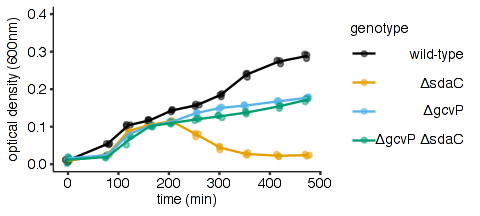

In [7]:
# plot
plot.width = 4
plot.height = 1.8
options(repr.plot.width=plot.width, repr.plot.height=plot.height)

ggplot(processed_data, aes(x=time, y=od, col=genotype)) +
geom_point(size=1, alpha=0.5, position = position_jitter(w = 5, h = 0)) + 
scale_colour_manual(values=cbPalette, 
                                   labels=c("wild-type", expression(italic("ΔsdaC")),
                                   expression(italic("ΔgcvP")), expression(italic("ΔgcvP ΔsdaC")))) +
scale_y_continuous(limits=c(0,0.4)) +
labs(x = "time (min)", y = "optical density (600nm)", col = "genotype") +
theme(strip.text=element_text(hjust=0.05)) +
stat_summary(aes(group=genotype), fun.y=mean, geom="line")

# save plot
ggsave('../pdf/fig_4d.pdf', width = plot.width, height = plot.height, units = 'in', device=cairo_pdf)